In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [11]:
df=pd.read_csv("C:/Users/denem/OneDrive/Belgeler/AI/EsnDegrmn1mtronrlmn.csv")

In [12]:
df.head()

,time,xVRMS,yVRMS,zVRMS,temp,cf,maxCf
0,2022-06-26 21:35:00,7.53931,4.94363,2.89816,48.95334,3.84012,NaN
1,2022-06-26 21:40:00,7.36773,4.82611,2.85156,49.05156,4.20228,NaN
2,2022-06-26 21:45:00,7.18102,4.84723,2.85830,48.84285,4.10223,NaN
3,2022-06-26 21:50:00,7.28957,4.86776,2.87858,48.89196,4.06978,NaN
4,2022-06-26 21:55:00,7.10303,4.77624,2.82860,48.79374,4.06219,NaN


In [13]:
df["cf"]=df["cf"].fillna(0)
df["maxCf"]=df["maxCf"].fillna(0)

In [14]:
df["cf"].isnull().sum()
df["maxCf"].isnull().sum()

0

In [15]:
df["newCF"]=df["cf"]+df["maxCf"]

In [16]:
df.isnull().sum()

time     0
xVRMS    0
yVRMS    0
zVRMS    0
temp     0
cf       0
maxCf    0
newCF    0
dtype: int64

In [17]:
del(df["cf"])
del(df["maxCf"])

In [18]:
len(df)

79832

In [19]:
df_t=df.set_index(pd.to_datetime(df["time"]))

In [20]:
df_t.head()

,time,xVRMS,yVRMS,zVRMS,temp,newCF
time,,,,,,
2022-06-26 21:35:00,2022-06-26 21:35:00,7.53931,4.94363,2.89816,48.95334,3.84012
2022-06-26 21:40:00,2022-06-26 21:40:00,7.36773,4.82611,2.85156,49.05156,4.20228
2022-06-26 21:45:00,2022-06-26 21:45:00,7.18102,4.84723,2.85830,48.84285,4.10223
2022-06-26 21:50:00,2022-06-26 21:50:00,7.28957,4.86776,2.87858,48.89196,4.06978
2022-06-26 21:55:00,2022-06-26 21:55:00,7.10303,4.77624,2.82860,48.79374,4.06219


In [21]:
def clean_limit(df_column, low_limit, up_limit=None):
    if up_limit is None:
        filtered = df_column[(df_column >= low_limit)]
        
    else:
        filtered = df_column.loc[(df_column >= low_limit) & (df_column <= up_limit)]
    return filtered

In [31]:
df_x_t=clean_limit(df_t["xVRMS"],low_limit=0.5)

In [32]:
df_x=clean_limit(df["xVRMS"],low_limit=0.5)

In [33]:
type(df_x),len(df_x)

(pandas.core.series.Series, 57455)

In [24]:
len(df_x)

57455

In [25]:
df_x.head()

time
2022-06-26 21:35:00    7.53931
2022-06-26 21:40:00    7.36773
2022-06-26 21:45:00    7.18102
2022-06-26 21:50:00    7.28957
2022-06-26 21:55:00    7.10303
Name: xVRMS, dtype: float64

## Train Test Split

In [26]:
def df_to_X_y(df, window_size=5):
  """
  Converts a pandas DataFrame to a tuple of NumPy arrays, where X is the input data and y is the target data.

  Args:
    df: A pandas DataFrame.
    window_size: The size of the sliding window.

  Returns:
    A tuple of NumPy arrays, where X is the input data and y is the target data.
  """

  # Convert the DataFrame to a NumPy array.
  df_as_np = df.to_numpy()

  # Create the input and target data.
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = df_as_np[i:i + window_size]
    X.append(row)
    label = df_as_np[i + window_size]
    y.append(label)

  # Return the input and target data as NumPy arrays.
  return np.array(X), np.array(y)

In [38]:
df_t.head()

,time,xVRMS,yVRMS,zVRMS,temp,newCF
time,,,,,,
2022-06-26 21:35:00,2022-06-26 21:35:00,7.53931,4.94363,2.89816,48.95334,3.84012
2022-06-26 21:40:00,2022-06-26 21:40:00,7.36773,4.82611,2.85156,49.05156,4.20228
2022-06-26 21:45:00,2022-06-26 21:45:00,7.18102,4.84723,2.85830,48.84285,4.10223
2022-06-26 21:50:00,2022-06-26 21:50:00,7.28957,4.86776,2.87858,48.89196,4.06978
2022-06-26 21:55:00,2022-06-26 21:55:00,7.10303,4.77624,2.82860,48.79374,4.06219


In [41]:
len(df_t)

79832

In [39]:
slct_df_t = df_t.loc[df_x_t.index]


In [42]:
slct_df_t.head(),len(slct_df_t)

(                                    time    xVRMS    yVRMS    zVRMS      temp  \
 time                                                                            
 2022-06-26 21:35:00  2022-06-26 21:35:00  7.53931  4.94363  2.89816  48.95334   
 2022-06-26 21:40:00  2022-06-26 21:40:00  7.36773  4.82611  2.85156  49.05156   
 2022-06-26 21:45:00  2022-06-26 21:45:00  7.18102  4.84723  2.85830  48.84285   
 2022-06-26 21:50:00  2022-06-26 21:50:00  7.28957  4.86776  2.87858  48.89196   
 2022-06-26 21:55:00  2022-06-26 21:55:00  7.10303  4.77624  2.82860  48.79374   
 
                        newCF  
 time                          
 2022-06-26 21:35:00  3.84012  
 2022-06-26 21:40:00  4.20228  
 2022-06-26 21:45:00  4.10223  
 2022-06-26 21:50:00  4.06978  
 2022-06-26 21:55:00  4.06219  ,
 57455)

In [43]:
slct_df=df.loc[df_x.index]

In [44]:
len(slct_df)

57455

In [46]:
X,y =df_to_X_y(slct_df["xVRMS"],1)
X.shape,y.shape

((57454, 1), (57454,))

In [47]:
X=X.reshape(-1,1)

In [48]:
total_size = len(X)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)

X_train, y_train = X[:train_size], y[:train_size]  # %80
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]  # %10
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]  # %10

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((45963, 1), (45963,), (5745, 1), (5745,), (5746, 1), (5746,))

## Build Model

In [28]:
!pip install xgboost


     ---------------------------------------- 70.9/70.9 MB 5.5 MB/s eta 0:00:00


In [29]:
import xgboost as xgb

In [78]:
slct_df.head()

,time,xVRMS,yVRMS,zVRMS,temp,newCF
time,,,,,,
2022-06-26 21:35:00,2022-06-26 21:35:00,7.53931,4.94363,2.89816,48.95334,3.84012
2022-06-26 21:40:00,2022-06-26 21:40:00,7.36773,4.82611,2.85156,49.05156,4.20228
2022-06-26 21:45:00,2022-06-26 21:45:00,7.18102,4.84723,2.85830,48.84285,4.10223
2022-06-26 21:50:00,2022-06-26 21:50:00,7.28957,4.86776,2.87858,48.89196,4.06978
2022-06-26 21:55:00,2022-06-26 21:55:00,7.10303,4.77624,2.82860,48.79374,4.06219


In [51]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Tarih sütununu datetime veri tipine dönüştürme
slct_df['time'] = pd.to_datetime(df['time'])

# Özellikler ve hedef değişken ayırma
X = slct_df['time'].values.reshape(-1, 1)  # Özellik: Tarih
y = slct_df['xVRMS']

In [53]:
X.shape,y.shape

((57455, 1), (57455,))

In [55]:
# Eğitim ve test veri setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
type(X_train),type(y_train)

(numpy.ndarray, numpy.ndarray)

In [58]:
# y_train veri tipini dönüştürme
y_train = np.array(y_train)

In [61]:
len(X_train),len(y_train)

(45964, 45964)

In [59]:
# XGBoost Regresyon modelini oluşturma
model = xgb.XGBRegressor()

# Eğitim verilerini DMatrix formatına dönüştürme
dtrain = xgb.DMatrix(X_train, label=y_train)

# Modeli eğitme
model.fit(dtrain)

# Test veri seti üzerinde tahmin yapma
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# Tahminleri değerlendirme (örnek olarak ortalama karesel hata - mean squared error)


XGBoostError: [14:31:07] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\data\array_interface.h:129: Check failed: typestr.size() == 3 || typestr.size() == 4: `typestr' should be of format <endian><type><size of type in bytes>.

In [54]:




# XGBoost Regresyon modelini oluşturma
model = xgb.XGBRegressor()

# Modeli eğitme
model.fit(X_train, y_train)

# Test veri seti üzerinde tahmin yapma
y_pred = model.predict(X_test)

# Tahminleri değerlendirme (MSE ve R-kare)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Ortalama Kare Hata (MSE):", mse)
print("R-kare (R^2):", r2)

# Gerçek ve tahmin edilen değerleri DataFrame'e dönüştürme
df_results = pd.DataFrame({'Tarih': pd.to_datetime(X_test.reshape(-1)), 'Gerçek Değerler': y_test, 'Tahminler': y_pred})

# Grafik çizdirme
plt.figure(figsize=(12, 6))
plt.plot(df['Tarih'], df['Satış'], color='blue', label='Gerçek Değerler')
plt.plot(df_results['Tarih'], df_results['Tahminler'], color='red', label='Tahminler')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.title('Satış Trendi ve Tahminler')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


XGBoostError: [14:26:38] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\data\array_interface.h:129: Check failed: typestr.size() == 3 || typestr.size() == 4: `typestr' should be of format <endian><type><size of type in bytes>.

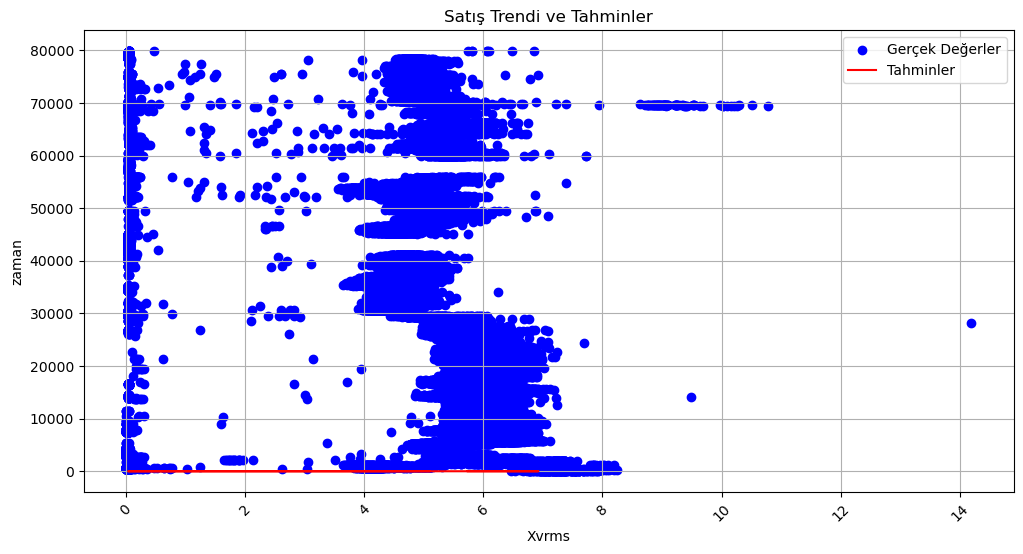

In [47]:
# Gerçek ve tahmin edilen değerleri DataFrame'e dönüştürme
df_results = pd.DataFrame({'Tarih': pd.to_datetime(X_test.reshape(-1)), 'Gerçek Değerler': y_test, 'Tahminler': y_pred})

# Grafik çizdirme
plt.figure(figsize=(12, 6))
plt.plot(slct['xVRMS'], df[''], color='blue', label='Gerçek Değerler')
plt.plot(df_results['Tarih'], df_results['Tahminler'], color='red', label='Tahminler')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.title('Satış Trendi ve Tahminler')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()